In [2]:
import numpy as np
import matplotlib.pyplot as plt

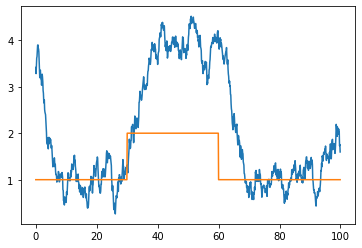

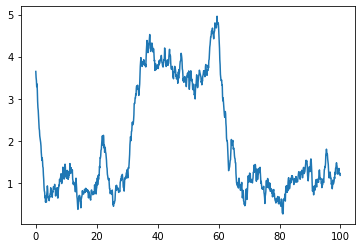

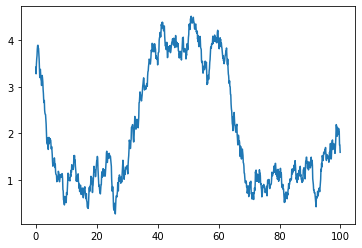

In [29]:
N = 300 # EnKF sample number
A = np.array([[0.9512,0],[0.0476,0.9512]])
h = 0.1

alpha1 = 1.
alpha2 = 1.
beta = 1.


def f(x,u):
    x1 = x[0,0]
    x2 = x[1,0]
    if x1<0:
        x1=0
    if x2<0:
        x2=0
    return np.array([[-alpha1*np.sqrt(x1)+beta*u],[alpha1*np.sqrt(x1)-alpha2*np.sqrt(x2)]],dtype='float')


B = np.array([[0.0975],[0.0024]])
C = np.array([0.,1.])
R = 0.0125
Q = 1e-3*np.array([[9.506,0.234],[0.234,9.512]])
y_data = open("Measured_output_nonlinear_case.txt",'r').read().split("\n")[1:-1]
y = np.zeros(len(y_data), dtype='float')

for i in range(len(y_data)):
    y[i] = y_data[i][:-2]
plt.plot(0.1*np.arange(len(y)),y)
#plt.show()

u_data = open("Input_nonlinear_case.txt",'r').read().split("\n")[1:-1]
u = np.zeros(len(u_data), dtype='float')

for i in range(len(u_data)):
    u[i] = u_data[i][:-2]
plt.plot(0.1*np.arange(len(u)),u)
plt.show()

x1_data = open("True_state_x1_nonlinear_case.txt",'r').read().split("\n")[1:-1]
x1 = np.zeros(len(x1_data), dtype='float')

for i in range(len(x1_data)):
    x1[i] = x1_data[i][:-2]
plt.plot(0.1*np.arange(len(x1)),x1)
plt.show()

x2_data = open("True_state_x2_nonlinear_case.txt",'r').read().split("\n")[1:-1]
x2 = np.zeros(len(x2_data), dtype='float')

for i in range(len(x2_data)):
    x2[i] = x2_data[i][:-2]
plt.plot(0.1*np.arange(len(x2)),x2)
plt.show()

In [30]:
x = np.zeros((len(y),N,2,1))
x[0,:,:,:] = np.random.normal(5.,1.,(N,2,1))
P_k = np.zeros((len(y),2,2),dtype='float')

for i in range(1,len(y)):
    for j in range(N):
        f1 = f(x[i-1,j], u[i-1])
        f2 = f(x[i-1,j]+0.5*h*f1, u[i-1])
        f3 = f(x[i-1,j]+0.5*h*f2, u[i-1])
        f4 = f(x[i-1,j]+h*f3, u[i-1])
        
        x[i,j] =  x[i-1,j] + (h/6.)*(f1 + 2*f2 + 2*f3 + f4) + np.reshape(np.random.multivariate_normal([0,0],Q,size=1), (2,1))
    
    x_for_cov = np.zeros((2,N),dtype='float')
    for k in range(N):
        x_for_cov[0,k] = x[i-1,k,0,0]
        x_for_cov[1,k] = x[i-1,k,1,0]
    P_k[i] = np.cov(x_for_cov)
        
    K_k = np.dot(P_k[i],np.reshape(C,(2,1)))/(np.dot(C,np.dot(P_k[i],np.reshape(C,(2,1))))[0] + R)
    K_kC = np.zeros((2,2),dtype='float')
    K_kC[0,0] = K_k[0,0]*C[0]
    K_kC[0,1] = K_k[0,0]*C[1]
    K_kC[1,0] = K_k[1,0]*C[0]
    K_kC[1,1] = K_k[1,0]*C[1]
    for j in range(N):
        x[i,j] = x[i,j] + K_k * (y[i] - np.dot(C, x[i,j])[0])
    if (i%100==0):
        print(i)

100
200
300
400
500
600
700
800
900


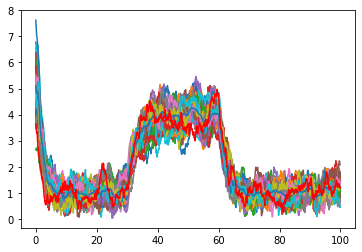

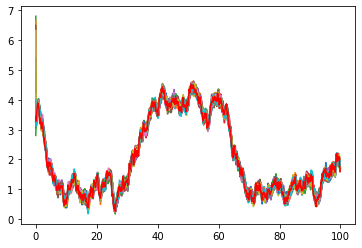

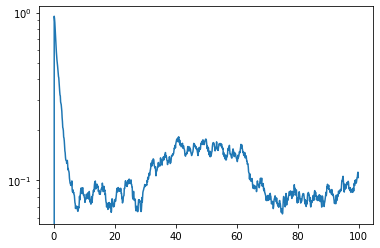

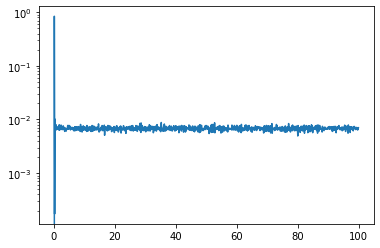

In [31]:
t = 0.1*np.arange(len(x2))

for i in range(0,N,5):
    plt.plot(t, x[:,i,0,0])

plt.plot(t, np.sum(x[:,:,0,0],axis=1)/N)

plt.plot(t, x1, 'r-')
plt.show()

for i in range(0,N,5):
    plt.plot(t, x[:,i,1,0])
plt.plot(t, x2, 'r-')
plt.show()

plt.semilogy(t[:],P_k[:,0,0][:])
plt.show()

plt.semilogy(t[:],P_k[:,1,1][:])
plt.show()

<ipython-input-32-0907e4f1cdc7>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


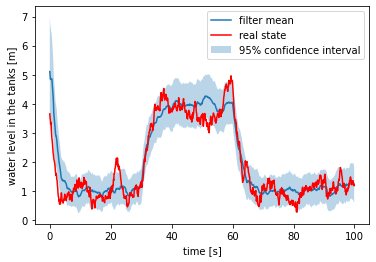

<ipython-input-32-0907e4f1cdc7>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


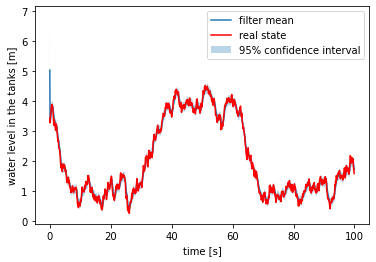

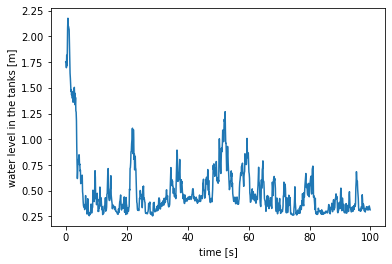

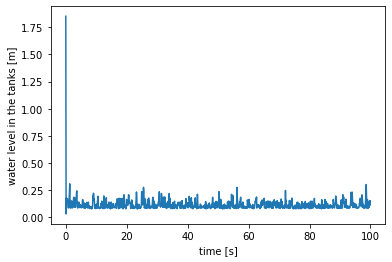

In [32]:
fig, ax = plt.subplots()
ax.plot(t, np.sum(x[:,:,0,0],axis=1)/N,label="filter mean")
ax.fill_between(t, np.sum(x[:,:,0,0],axis=1)/N-1.96*np.std(x[:,:,0,0],axis=1), np.sum(x[:,:,0,0],axis=1)/N+1.96*np.std(x[:,:,0,0],axis=1) ,alpha=0.3,label="95% confidence interval")
plt.plot(t, x1, 'r-',label="real state")
fig.show()
plt.xlabel("time [s]")
plt.ylabel("water level in the tanks [m]")
plt.legend()
plt.savefig("multi_sample_nonlinear_x1_N"+str(N)+".png")
plt.show()


fig, ax = plt.subplots()
ax.plot(t, np.sum(x[:,:,1,0],axis=1)/N,label="filter mean")
ax.fill_between(t, np.sum(x[:,:,1,0],axis=1)/N-1.96*np.std(x[:,:,1,0],axis=1), np.sum(x[:,:,1,0],axis=1)/N+1.96*np.std(x[:,:,1,0],axis=1) ,alpha=0.3,label="95% confidence interval")
plt.plot(t, x2, 'r-',label="real state")
fig.show()

plt.xlabel("time [s]")
plt.ylabel("water level in the tanks [m]")
plt.legend()
plt.savefig("multi_sample_nonlinear_x2_N"+str(N)+".png")
plt.show()


MSE1 = np.zeros(len(t),dtype='float')
MSE2 = np.zeros(len(t),dtype='float')
for i in range(len(MSE1)):
    MSE1[i] = np.sum((x[i,:,0,0]-x1[i])**2)/float(N)
    MSE2[i] = np.sum((x[i,:,1,0]-x2[i])**2)/float(N)

plt.plot(t, np.sqrt(MSE1))
plt.xlabel("time [s]")
plt.ylabel("water level in the tanks [m]")
plt.savefig("RMSD_x1_nonlinear_EnKF.png")
plt.show()

plt.plot(t, np.sqrt(MSE2))
plt.xlabel("time [s]")
plt.ylabel("water level in the tanks [m]")
plt.savefig("RMSD_x2_nonlinear_EnKF.png")
plt.show()